In [1]:
import numpy as np
from torch import nn
from torch.nn import functional as F
import torch
from torch import optim
from torchvision import datasets,transforms
from torchinfo import summary
import albumentations as A
from albumentations.pytorch import ToTensorV2

from transformations import (train_transforms,test_transforms,no_transforms)

from trainer import Trainer
from tester import Tester
from utlis import visualize_data,show_misclassified_images,device,is_cuda
from viz import plot_class_distribution, plot_confusion_matrix, plot_curves
from dataloader import CIFAR10Dataset,CIFAR10DataLoader
from models import ConvLayer,TransBlock,DepthwiseConvLayer


# Augmentation
atrain_dataset = CIFAR10Dataset(root='../data/',train=True,Atransforms=train_transforms,download=False)
atest_dataset  = CIFAR10Dataset(root='../data/',train=False,Atransforms=test_transforms,download=False)
acifar = CIFAR10DataLoader(batch_size=512,is_cuda_available=True)
atrain_loader, atest_loader = acifar.get_loader(atrain_dataset,atest_dataset)


# No Augmentation
train_dataset = CIFAR10Dataset(root='../data/',train=True,Atransforms=test_transforms,download=False)
test_dataset  = CIFAR10Dataset(root='../data/',train=False,Atransforms=test_transforms,download=False)
cifar = CIFAR10DataLoader(batch_size=512,is_cuda_available=True)
train_loader, test_loader = cifar.get_loader(train_dataset,test_dataset)

In [2]:
torch.cuda.amp.autocast(enabled=True, dtype=torch.float16, cache_enabled=False)

C:\Users\muthu\Documents\TSAI\session 9\utlis.py:42: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


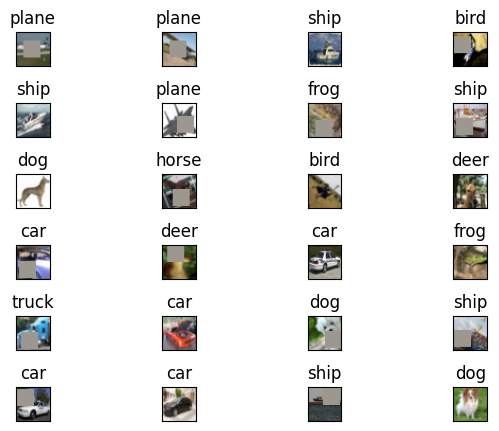

In [3]:
visualize_data(atrain_loader,classes=acifar.classes,num_figures=24)

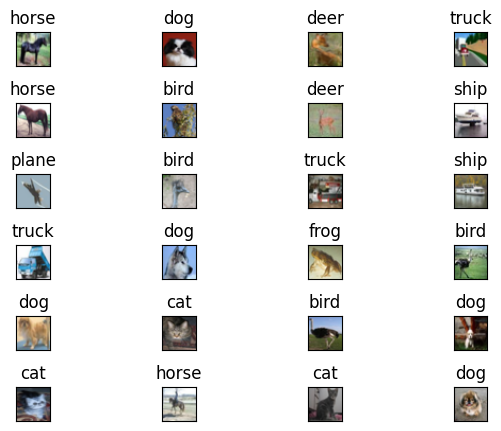

In [4]:
visualize_data(train_loader,classes=acifar.classes,num_figures=24)

**large model with no augmentation**

In [5]:
dp_rate = 0.1
class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        self.conv1 = ConvLayer(inc=3,outc=8,k=3,p=1,s=1,d=1,dp_rate=dp_rate)
        
        self.conv2 = ConvLayer(         inc=8,outc=16,k=3,p=1,s=1,d=1,dp_rate=dp_rate)
        self.dep2  = DepthwiseConvLayer(inc=8,outc=16,p=1,s=1,dp_rate=dp_rate)
        self.dil2  = ConvLayer(         inc=8,outc=16,k=3,p=2,s=1,d=2,dp_rate=dp_rate)

        self.conv3 = ConvLayer(         inc=16,outc=32,k=3,p=1,s=1,d=1,dp_rate=dp_rate)
        self.dep3  = DepthwiseConvLayer(inc=16,outc=32,p=1,s=1,dp_rate=dp_rate)
        self.dil3  = ConvLayer(         inc=16,outc=32,k=3,p=2,s=1,d=2,dp_rate=dp_rate)

        self.trans4 = TransBlock(56,16,p=0,s=2)


        self.conv5 = ConvLayer(16,32,k=3,p=1,s=1,d=1,dp_rate=dp_rate)

        self.conv6 = ConvLayer(         inc=32,outc=48,k=3,p=1,s=1,d=1,dp_rate=dp_rate)
        self.dep6  = DepthwiseConvLayer(inc=32,outc=48,p=1,s=1,dp_rate=dp_rate)
        self.dil6  = ConvLayer(         inc=32,outc=48,k=3,p=2,s=1,d=2,dp_rate=dp_rate)

        self.conv7 = ConvLayer(         inc=48,outc=56,k=3,p=1,s=1,d=1,dp_rate=dp_rate)
        self.dep7  = DepthwiseConvLayer(inc=48,outc=56,p=1,s=1,dp_rate=dp_rate)
        self.dil7  = ConvLayer(         inc=48,outc=56,k=3,p=2,s=1,d=2,dp_rate=dp_rate)
      
        self.trans8 = TransBlock(136,24,p=0,s=2)

        
        self.conv9 = ConvLayer(24,40,k=3,p=1,s=1,d=1,dp_rate=dp_rate)

        self.conv10 = ConvLayer(         inc=40,outc=48,k=3,p=1,s=1,d=1,dp_rate=dp_rate)
        self.dep10  = DepthwiseConvLayer(inc=40,outc=48,p=1,s=1,dp_rate=dp_rate)
        self.dil10  = ConvLayer(         inc=40,outc=48,k=3,p=4,s=1,d=4,dp_rate=dp_rate)


        self.conv_ = ConvLayer(         inc=48,outc=48,k=3,p=1,s=1,d=1,dp_rate=dp_rate)
        self.dep_  = DepthwiseConvLayer(inc=48,outc=48,p=1,s=1,dp_rate=dp_rate)
        self.dil_  = ConvLayer(         inc=48,outc=48,k=3,p=4,s=1,d=4,dp_rate=dp_rate)

        self.trans11 = TransBlock(88,40,p=0,s=1)
        self.trans12 = TransBlock(40,20,p=0,s=1)
        self.out = TransBlock(inc=20,outc=10,p=0,s=1)
        self.gap = nn.AdaptiveAvgPool2d(output_size=1)
        
    
    def forward(self,x):  
        x0 = self.conv1(x)
        x1 = self.dep2(x0) + self.conv2(x0) + self.dil2(x0) 
        x2 = self.dep3(x1) + self.conv3(x1) + self.dil3(x1) 
        x3 = torch.concat((x0,x1,x2),dim=1)
        x4 = self.trans4(x3)

        x5 = self.conv5(x4)
        x6 = self.conv6(x5) + self.dep6(x5) + self.dil6(x5)
        x7 = self.conv7(x6)+ self.dep7(x6)+ self.dil7(x6)
        x8 = torch.concat((x5,x6,x7),dim=1)
        x9  = self.trans8(x8)

        x10 = self.conv9(x9)
        x11 = self.conv10(x10) + self.dep10(x10) + self.dil10(x10)
        x11 = self.conv_(x11) + self.dep_(x11) + self.dil_(x11)
        x12 = torch.concat((x10,x11),dim=1)
        x  = self.trans11(x12)
        x  = self.trans12(x)
        
        x = self.out(x)
        x = self.gap(x)
        return  F.log_softmax(x.view(-1,10), dim=1)


model = Net().to(device=device)
summary(model,input_size=(1,3,32,32),device=device)

Layer (type:depth-idx)                   Output Shape              Param #
Net                                      [1, 10]                   --
├─ConvLayer: 1-1                         [1, 8, 32, 32]            --
│    └─Sequential: 2-1                   [1, 8, 32, 32]            --
│    │    └─Conv2d: 3-1                  [1, 8, 32, 32]            216
│    │    └─BatchNorm2d: 3-2             [1, 8, 32, 32]            16
│    │    └─ReLU: 3-3                    [1, 8, 32, 32]            --
│    │    └─Dropout2d: 3-4               [1, 8, 32, 32]            --
├─DepthwiseConvLayer: 1-2                [1, 16, 32, 32]           --
│    └─Sequential: 2-2                   [1, 16, 32, 32]           --
│    │    └─Conv2d: 3-5                  [1, 8, 32, 32]            72
│    │    └─Conv2d: 3-6                  [1, 16, 32, 32]           128
│    │    └─ReLU: 3-7                    [1, 16, 32, 32]           --
│    │    └─BatchNorm2d: 3-8             [1, 16, 32, 32]           32
│    │    └─D

In [6]:
prev_test_loss = float('inf')

optimizer = optim.SGD(params=model.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,mode='min',factor=0.1,patience=3)
criterion = nn.NLLLoss()
trainer = Trainer(model=model, train_loader=train_loader, optimizer=optimizer, criterion=criterion, device=device)
tester = Tester(model=model, test_loader=test_loader,criterion=criterion, device=device)

for epoch in range(1, 101):
    trainer.train(epoch=epoch)
    _,test_loss = tester.test()
    if prev_test_loss>test_loss:
        torch.save(obj=model.state_dict(),f='./bmodels/model4.pth')
    scheduler.step(test_loss)

EPOCH = 1 | LR = 0.1 | Loss = 1.56 | Batch = 97 | Accuracy = 30.67: 100%|███| 98/98 [00:41<00:00,  2.36it/s]


Test set: Average loss: 0.0031, Accuracy: 4093/10000 (40.93%)


EPOCH = 2 | LR = 0.1 | Loss = 1.41 | Batch = 97 | Accuracy = 44.10: 100%|███| 98/98 [00:40<00:00,  2.40it/s]


Test set: Average loss: 0.0027, Accuracy: 5018/10000 (50.18%)


EPOCH = 3 | LR = 0.1 | Loss = 1.28 | Batch = 97 | Accuracy = 51.28: 100%|███| 98/98 [00:42<00:00,  2.32it/s]


Test set: Average loss: 0.0024, Accuracy: 5718/10000 (57.18%)


EPOCH = 4 | LR = 0.1 | Loss = 1.12 | Batch = 97 | Accuracy = 57.57: 100%|███| 98/98 [00:42<00:00,  2.29it/s]


Test set: Average loss: 0.0020, Accuracy: 6426/10000 (64.26%)


EPOCH = 5 | LR = 0.1 | Loss = 0.92 | Batch = 97 | Accuracy = 62.06: 100%|███| 98/98 [00:42<00:00,  2.31it/s]


Test set: Average loss: 0.0018, Accuracy: 6695/10000 (66.95%)


EPOCH = 6 | LR = 0.1 | Loss = 0.92 | Batch = 97 | Accuracy = 65.29: 100%|███| 98/98 [00:42<00:00,  2.30it/s]


Test set: Average loss: 0.0017, Accuracy: 6992/10000 (69.92%)


EPOCH = 7 | LR = 0.1 | Loss = 0.85 | Batch = 97 | Accuracy = 67.62: 100%|███| 98/98 [00:43<00:00,  2.28it/s]


Test set: Average loss: 0.0016, Accuracy: 7116/10000 (71.16%)


EPOCH = 8 | LR = 0.1 | Loss = 0.84 | Batch = 97 | Accuracy = 69.32: 100%|███| 98/98 [00:41<00:00,  2.38it/s]


Test set: Average loss: 0.0016, Accuracy: 7252/10000 (72.52%)


EPOCH = 9 | LR = 0.1 | Loss = 0.80 | Batch = 97 | Accuracy = 70.95: 100%|███| 98/98 [00:41<00:00,  2.35it/s]


Test set: Average loss: 0.0016, Accuracy: 7318/10000 (73.18%)


EPOCH = 10 | LR = 0.1 | Loss = 0.91 | Batch = 97 | Accuracy = 72.08: 100%|██| 98/98 [00:42<00:00,  2.32it/s]


Test set: Average loss: 0.0015, Accuracy: 7415/10000 (74.15%)


EPOCH = 11 | LR = 0.1 | Loss = 0.79 | Batch = 97 | Accuracy = 73.43: 100%|██| 98/98 [00:42<00:00,  2.33it/s]


Test set: Average loss: 0.0014, Accuracy: 7514/10000 (75.14%)


EPOCH = 12 | LR = 0.1 | Loss = 0.72 | Batch = 97 | Accuracy = 74.32: 100%|██| 98/98 [00:42<00:00,  2.33it/s]


Test set: Average loss: 0.0014, Accuracy: 7512/10000 (75.12%)


EPOCH = 13 | LR = 0.1 | Loss = 0.76 | Batch = 97 | Accuracy = 75.03: 100%|██| 98/98 [00:42<00:00,  2.29it/s]


Test set: Average loss: 0.0014, Accuracy: 7605/10000 (76.05%)


EPOCH = 14 | LR = 0.1 | Loss = 0.72 | Batch = 97 | Accuracy = 75.90: 100%|██| 98/98 [00:41<00:00,  2.34it/s]


Test set: Average loss: 0.0013, Accuracy: 7673/10000 (76.73%)


EPOCH = 15 | LR = 0.1 | Loss = 0.63 | Batch = 97 | Accuracy = 76.44: 100%|██| 98/98 [00:41<00:00,  2.33it/s]


Test set: Average loss: 0.0012, Accuracy: 7871/10000 (78.71%)


EPOCH = 16 | LR = 0.1 | Loss = 0.70 | Batch = 97 | Accuracy = 77.31: 100%|██| 98/98 [00:42<00:00,  2.33it/s]


Test set: Average loss: 0.0012, Accuracy: 7942/10000 (79.42%)


EPOCH = 17 | LR = 0.1 | Loss = 0.61 | Batch = 97 | Accuracy = 77.85: 100%|██| 98/98 [00:42<00:00,  2.31it/s]


Test set: Average loss: 0.0012, Accuracy: 7975/10000 (79.75%)


EPOCH = 18 | LR = 0.1 | Loss = 0.57 | Batch = 97 | Accuracy = 78.54: 100%|██| 98/98 [00:42<00:00,  2.32it/s]


Test set: Average loss: 0.0012, Accuracy: 7954/10000 (79.54%)


EPOCH = 19 | LR = 0.1 | Loss = 0.63 | Batch = 97 | Accuracy = 78.66: 100%|██| 98/98 [00:41<00:00,  2.33it/s]


Test set: Average loss: 0.0012, Accuracy: 7965/10000 (79.65%)


EPOCH = 20 | LR = 0.1 | Loss = 0.61 | Batch = 97 | Accuracy = 79.41: 100%|██| 98/98 [00:42<00:00,  2.32it/s]


Test set: Average loss: 0.0012, Accuracy: 7912/10000 (79.12%)


EPOCH = 21 | LR = 0.1 | Loss = 0.51 | Batch = 97 | Accuracy = 79.75: 100%|██| 98/98 [00:42<00:00,  2.33it/s]


Test set: Average loss: 0.0012, Accuracy: 8021/10000 (80.21%)


EPOCH = 22 | LR = 0.1 | Loss = 0.64 | Batch = 97 | Accuracy = 80.25: 100%|██| 98/98 [00:42<00:00,  2.33it/s]


Test set: Average loss: 0.0012, Accuracy: 8060/10000 (80.60%)


EPOCH = 23 | LR = 0.1 | Loss = 0.53 | Batch = 97 | Accuracy = 80.66: 100%|██| 98/98 [00:42<00:00,  2.33it/s]


Test set: Average loss: 0.0012, Accuracy: 7955/10000 (79.55%)


EPOCH = 24 | LR = 0.1 | Loss = 0.63 | Batch = 97 | Accuracy = 80.82: 100%|██| 98/98 [00:42<00:00,  2.33it/s]


Test set: Average loss: 0.0012, Accuracy: 7909/10000 (79.09%)


EPOCH = 25 | LR = 0.1 | Loss = 0.51 | Batch = 97 | Accuracy = 81.40: 100%|██| 98/98 [00:42<00:00,  2.33it/s]


Test set: Average loss: 0.0012, Accuracy: 8081/10000 (80.81%)


EPOCH = 26 | LR = 0.1 | Loss = 0.54 | Batch = 97 | Accuracy = 81.66: 100%|██| 98/98 [00:42<00:00,  2.33it/s]


Test set: Average loss: 0.0011, Accuracy: 8065/10000 (80.65%)


EPOCH = 27 | LR = 0.1 | Loss = 0.58 | Batch = 97 | Accuracy = 81.80: 100%|██| 98/98 [00:42<00:00,  2.33it/s]


Test set: Average loss: 0.0011, Accuracy: 8106/10000 (81.06%)


EPOCH = 28 | LR = 0.1 | Loss = 0.48 | Batch = 97 | Accuracy = 82.35: 100%|██| 98/98 [00:42<00:00,  2.32it/s]


Test set: Average loss: 0.0011, Accuracy: 8113/10000 (81.13%)


EPOCH = 29 | LR = 0.1 | Loss = 0.48 | Batch = 97 | Accuracy = 82.47: 100%|██| 98/98 [00:42<00:00,  2.32it/s]


Test set: Average loss: 0.0012, Accuracy: 8029/10000 (80.29%)


EPOCH = 30 | LR = 0.1 | Loss = 0.54 | Batch = 97 | Accuracy = 82.86: 100%|██| 98/98 [00:42<00:00,  2.32it/s]


Test set: Average loss: 0.0011, Accuracy: 8185/10000 (81.85%)


EPOCH = 31 | LR = 0.1 | Loss = 0.52 | Batch = 97 | Accuracy = 83.21: 100%|██| 98/98 [00:42<00:00,  2.32it/s]


Test set: Average loss: 0.0012, Accuracy: 8048/10000 (80.48%)


EPOCH = 32 | LR = 0.1 | Loss = 0.48 | Batch = 97 | Accuracy = 83.55: 100%|██| 98/98 [00:42<00:00,  2.33it/s]


Test set: Average loss: 0.0012, Accuracy: 8090/10000 (80.90%)


EPOCH = 33 | LR = 0.1 | Loss = 0.46 | Batch = 97 | Accuracy = 83.62: 100%|██| 98/98 [00:42<00:00,  2.32it/s]


Test set: Average loss: 0.0011, Accuracy: 8104/10000 (81.04%)


EPOCH = 34 | LR = 0.1 | Loss = 0.45 | Batch = 97 | Accuracy = 83.91: 100%|██| 98/98 [00:42<00:00,  2.31it/s]


Test set: Average loss: 0.0011, Accuracy: 8179/10000 (81.79%)


EPOCH = 35 | LR = 0.010000000000000002 | Loss = 0.40 | Batch = 97 | Accuracy = 85.77: 100%|█| 98/98 [00:40<0


Test set: Average loss: 0.0010, Accuracy: 8256/10000 (82.56%)


EPOCH = 36 | LR = 0.010000000000000002 | Loss = 0.34 | Batch = 97 | Accuracy = 86.50: 100%|█| 98/98 [00:40<0


Test set: Average loss: 0.0010, Accuracy: 8305/10000 (83.05%)


EPOCH = 37 | LR = 0.010000000000000002 | Loss = 0.32 | Batch = 97 | Accuracy = 86.75: 100%|█| 98/98 [00:40<0


Test set: Average loss: 0.0010, Accuracy: 8305/10000 (83.05%)


EPOCH = 38 | LR = 0.010000000000000002 | Loss = 0.37 | Batch = 97 | Accuracy = 87.14: 100%|█| 98/98 [00:40<0


Test set: Average loss: 0.0010, Accuracy: 8315/10000 (83.15%)


EPOCH = 39 | LR = 0.010000000000000002 | Loss = 0.38 | Batch = 97 | Accuracy = 87.38: 100%|█| 98/98 [00:40<0


Test set: Average loss: 0.0010, Accuracy: 8337/10000 (83.37%)


EPOCH = 40 | LR = 0.010000000000000002 | Loss = 0.33 | Batch = 97 | Accuracy = 87.22: 100%|█| 98/98 [00:40<0


Test set: Average loss: 0.0011, Accuracy: 8294/10000 (82.94%)


EPOCH = 41 | LR = 0.0010000000000000002 | Loss = 0.33 | Batch = 97 | Accuracy = 87.47: 100%|█| 98/98 [00:40<


Test set: Average loss: 0.0010, Accuracy: 8315/10000 (83.15%)


EPOCH = 42 | LR = 0.0010000000000000002 | Loss = 0.28 | Batch = 97 | Accuracy = 87.53: 100%|█| 98/98 [00:40<


Test set: Average loss: 0.0010, Accuracy: 8330/10000 (83.30%)


EPOCH = 43 | LR = 0.0010000000000000002 | Loss = 0.39 | Batch = 97 | Accuracy = 87.58: 100%|█| 98/98 [00:40<


Test set: Average loss: 0.0010, Accuracy: 8317/10000 (83.17%)


EPOCH = 44 | LR = 0.0010000000000000002 | Loss = 0.35 | Batch = 97 | Accuracy = 87.81: 100%|█| 98/98 [00:40<


Test set: Average loss: 0.0010, Accuracy: 8321/10000 (83.21%)


EPOCH = 45 | LR = 0.00010000000000000003 | Loss = 0.34 | Batch = 97 | Accuracy = 87.64: 100%|█| 98/98 [00:40


Test set: Average loss: 0.0010, Accuracy: 8315/10000 (83.15%)


EPOCH = 46 | LR = 0.00010000000000000003 | Loss = 0.46 | Batch = 97 | Accuracy = 87.83: 100%|█| 98/98 [00:40


Test set: Average loss: 0.0010, Accuracy: 8321/10000 (83.21%)


EPOCH = 47 | LR = 0.00010000000000000003 | Loss = 0.34 | Batch = 97 | Accuracy = 87.69: 100%|█| 98/98 [00:40


Test set: Average loss: 0.0010, Accuracy: 8316/10000 (83.16%)


EPOCH = 48 | LR = 0.00010000000000000003 | Loss = 0.32 | Batch = 97 | Accuracy = 87.67: 100%|█| 98/98 [00:40


Test set: Average loss: 0.0010, Accuracy: 8324/10000 (83.24%)


EPOCH = 49 | LR = 0.00010000000000000003 | Loss = 0.34 | Batch = 97 | Accuracy = 87.58: 100%|█| 98/98 [00:40


Test set: Average loss: 0.0010, Accuracy: 8331/10000 (83.31%)


EPOCH = 50 | LR = 0.00010000000000000003 | Loss = 0.44 | Batch = 97 | Accuracy = 87.58: 100%|█| 98/98 [00:40


Test set: Average loss: 0.0010, Accuracy: 8319/10000 (83.19%)


EPOCH = 51 | LR = 0.00010000000000000003 | Loss = 0.32 | Batch = 97 | Accuracy = 87.72: 100%|█| 98/98 [00:40


Test set: Average loss: 0.0010, Accuracy: 8328/10000 (83.28%)


EPOCH = 52 | LR = 0.00010000000000000003 | Loss = 0.37 | Batch = 97 | Accuracy = 87.45: 100%|█| 98/98 [00:40


Test set: Average loss: 0.0010, Accuracy: 8325/10000 (83.25%)


EPOCH = 53 | LR = 0.00010000000000000003 | Loss = 0.34 | Batch = 97 | Accuracy = 87.57: 100%|█| 98/98 [00:40


Test set: Average loss: 0.0010, Accuracy: 8326/10000 (83.26%)


EPOCH = 54 | LR = 0.00010000000000000003 | Loss = 0.36 | Batch = 97 | Accuracy = 87.56: 100%|█| 98/98 [00:40


Test set: Average loss: 0.0010, Accuracy: 8327/10000 (83.27%)


EPOCH = 55 | LR = 0.00010000000000000003 | Loss = 0.37 | Batch = 97 | Accuracy = 87.77: 100%|█| 98/98 [00:40


Test set: Average loss: 0.0010, Accuracy: 8327/10000 (83.27%)


EPOCH = 56 | LR = 1.0000000000000004e-05 | Loss = 0.34 | Batch = 97 | Accuracy = 87.69: 100%|█| 98/98 [00:40


Test set: Average loss: 0.0010, Accuracy: 8328/10000 (83.28%)


EPOCH = 57 | LR = 1.0000000000000004e-05 | Loss = 0.30 | Batch = 97 | Accuracy = 87.63: 100%|█| 98/98 [00:40


Test set: Average loss: 0.0010, Accuracy: 8327/10000 (83.27%)


EPOCH = 58 | LR = 1.0000000000000004e-05 | Loss = 0.35 | Batch = 97 | Accuracy = 87.76: 100%|█| 98/98 [00:40


Test set: Average loss: 0.0010, Accuracy: 8337/10000 (83.37%)


EPOCH = 59 | LR = 1.0000000000000004e-05 | Loss = 0.29 | Batch = 97 | Accuracy = 87.54: 100%|█| 98/98 [00:40


Test set: Average loss: 0.0010, Accuracy: 8332/10000 (83.32%)


EPOCH = 60 | LR = 1.0000000000000004e-06 | Loss = 0.27 | Batch = 97 | Accuracy = 87.66: 100%|█| 98/98 [00:40


Test set: Average loss: 0.0010, Accuracy: 8325/10000 (83.25%)


EPOCH = 61 | LR = 1.0000000000000004e-06 | Loss = 0.36 | Batch = 97 | Accuracy = 87.79: 100%|█| 98/98 [00:40


Test set: Average loss: 0.0010, Accuracy: 8326/10000 (83.26%)


EPOCH = 62 | LR = 1.0000000000000004e-06 | Loss = 0.32 | Batch = 97 | Accuracy = 87.72: 100%|█| 98/98 [00:40


Test set: Average loss: 0.0010, Accuracy: 8333/10000 (83.33%)


EPOCH = 63 | LR = 1.0000000000000004e-06 | Loss = 0.36 | Batch = 97 | Accuracy = 87.78: 100%|█| 98/98 [00:40


Test set: Average loss: 0.0010, Accuracy: 8336/10000 (83.36%)


EPOCH = 64 | LR = 1.0000000000000004e-06 | Loss = 0.27 | Batch = 97 | Accuracy = 87.68: 100%|█| 98/98 [00:40


Test set: Average loss: 0.0010, Accuracy: 8337/10000 (83.37%)


EPOCH = 65 | LR = 1.0000000000000004e-06 | Loss = 0.33 | Batch = 97 | Accuracy = 87.78: 100%|█| 98/98 [00:40


Test set: Average loss: 0.0010, Accuracy: 8320/10000 (83.20%)


EPOCH = 66 | LR = 1.0000000000000004e-06 | Loss = 0.45 | Batch = 97 | Accuracy = 87.77: 100%|█| 98/98 [00:40


Test set: Average loss: 0.0010, Accuracy: 8333/10000 (83.33%)


EPOCH = 67 | LR = 1.0000000000000004e-06 | Loss = 0.33 | Batch = 97 | Accuracy = 87.93: 100%|█| 98/98 [00:40


Test set: Average loss: 0.0010, Accuracy: 8328/10000 (83.28%)


EPOCH = 68 | LR = 1.0000000000000005e-07 | Loss = 0.39 | Batch = 97 | Accuracy = 87.62: 100%|█| 98/98 [00:40


Test set: Average loss: 0.0010, Accuracy: 8339/10000 (83.39%)


EPOCH = 69 | LR = 1.0000000000000005e-07 | Loss = 0.30 | Batch = 97 | Accuracy = 87.63: 100%|█| 98/98 [00:40


Test set: Average loss: 0.0010, Accuracy: 8329/10000 (83.29%)


EPOCH = 70 | LR = 1.0000000000000005e-07 | Loss = 0.29 | Batch = 97 | Accuracy = 87.72: 100%|█| 98/98 [00:40


Test set: Average loss: 0.0010, Accuracy: 8325/10000 (83.25%)


EPOCH = 71 | LR = 1.0000000000000005e-07 | Loss = 0.29 | Batch = 97 | Accuracy = 87.71: 100%|█| 98/98 [00:40


Test set: Average loss: 0.0010, Accuracy: 8338/10000 (83.38%)


EPOCH = 72 | LR = 1.0000000000000005e-08 | Loss = 0.32 | Batch = 97 | Accuracy = 87.78: 100%|█| 98/98 [00:41


Test set: Average loss: 0.0010, Accuracy: 8336/10000 (83.36%)


EPOCH = 73 | LR = 1.0000000000000005e-08 | Loss = 0.37 | Batch = 97 | Accuracy = 87.73: 100%|█| 98/98 [00:41


Test set: Average loss: 0.0010, Accuracy: 8329/10000 (83.29%)


EPOCH = 74 | LR = 1.0000000000000005e-08 | Loss = 0.42 | Batch = 97 | Accuracy = 87.71: 100%|█| 98/98 [00:41


Test set: Average loss: 0.0010, Accuracy: 8334/10000 (83.34%)


EPOCH = 75 | LR = 1.0000000000000005e-08 | Loss = 0.36 | Batch = 97 | Accuracy = 87.82: 100%|█| 98/98 [00:41


Test set: Average loss: 0.0010, Accuracy: 8324/10000 (83.24%)


EPOCH = 76 | LR = 1.0000000000000005e-08 | Loss = 0.32 | Batch = 97 | Accuracy = 87.66: 100%|█| 98/98 [00:41


Test set: Average loss: 0.0010, Accuracy: 8327/10000 (83.27%)


EPOCH = 77 | LR = 1.0000000000000005e-08 | Loss = 0.36 | Batch = 97 | Accuracy = 87.66: 100%|█| 98/98 [00:41


Test set: Average loss: 0.0010, Accuracy: 8339/10000 (83.39%)


EPOCH = 78 | LR = 1.0000000000000005e-08 | Loss = 0.28 | Batch = 97 | Accuracy = 87.49: 100%|█| 98/98 [00:41


Test set: Average loss: 0.0010, Accuracy: 8336/10000 (83.36%)


EPOCH = 79 | LR = 1.0000000000000005e-08 | Loss = 0.34 | Batch = 97 | Accuracy = 87.71: 100%|█| 98/98 [00:40


Test set: Average loss: 0.0010, Accuracy: 8322/10000 (83.22%)


EPOCH = 80 | LR = 1.0000000000000005e-08 | Loss = 0.37 | Batch = 97 | Accuracy = 87.60: 100%|█| 98/98 [00:40


Test set: Average loss: 0.0010, Accuracy: 8318/10000 (83.18%)


EPOCH = 81 | LR = 1.0000000000000005e-08 | Loss = 0.34 | Batch = 97 | Accuracy = 87.49: 100%|█| 98/98 [00:40


Test set: Average loss: 0.0010, Accuracy: 8326/10000 (83.26%)


EPOCH = 82 | LR = 1.0000000000000005e-08 | Loss = 0.40 | Batch = 97 | Accuracy = 87.66: 100%|█| 98/98 [00:40


Test set: Average loss: 0.0011, Accuracy: 8324/10000 (83.24%)


EPOCH = 83 | LR = 1.0000000000000005e-08 | Loss = 0.39 | Batch = 97 | Accuracy = 87.79: 100%|█| 98/98 [00:40


Test set: Average loss: 0.0010, Accuracy: 8329/10000 (83.29%)


EPOCH = 84 | LR = 1.0000000000000005e-08 | Loss = 0.29 | Batch = 97 | Accuracy = 87.93: 100%|█| 98/98 [00:40


Test set: Average loss: 0.0010, Accuracy: 8328/10000 (83.28%)


EPOCH = 85 | LR = 1.0000000000000005e-08 | Loss = 0.29 | Batch = 97 | Accuracy = 87.56: 100%|█| 98/98 [00:40


Test set: Average loss: 0.0010, Accuracy: 8337/10000 (83.37%)


EPOCH = 86 | LR = 1.0000000000000005e-08 | Loss = 0.28 | Batch = 97 | Accuracy = 87.80: 100%|█| 98/98 [00:40


Test set: Average loss: 0.0010, Accuracy: 8327/10000 (83.27%)


EPOCH = 87 | LR = 1.0000000000000005e-08 | Loss = 0.38 | Batch = 97 | Accuracy = 87.62: 100%|█| 98/98 [00:40


Test set: Average loss: 0.0010, Accuracy: 8327/10000 (83.27%)


EPOCH = 88 | LR = 1.0000000000000005e-08 | Loss = 0.35 | Batch = 97 | Accuracy = 87.66: 100%|█| 98/98 [00:40


Test set: Average loss: 0.0010, Accuracy: 8332/10000 (83.32%)


EPOCH = 89 | LR = 1.0000000000000005e-08 | Loss = 0.41 | Batch = 97 | Accuracy = 87.88: 100%|█| 98/98 [00:40


Test set: Average loss: 0.0010, Accuracy: 8334/10000 (83.34%)


EPOCH = 90 | LR = 1.0000000000000005e-08 | Loss = 0.32 | Batch = 97 | Accuracy = 87.77: 100%|█| 98/98 [00:40


Test set: Average loss: 0.0010, Accuracy: 8336/10000 (83.36%)


EPOCH = 91 | LR = 1.0000000000000005e-08 | Loss = 0.31 | Batch = 97 | Accuracy = 87.77: 100%|█| 98/98 [00:40


Test set: Average loss: 0.0010, Accuracy: 8328/10000 (83.28%)


EPOCH = 92 | LR = 1.0000000000000005e-08 | Loss = 0.36 | Batch = 97 | Accuracy = 87.91: 100%|█| 98/98 [00:40


Test set: Average loss: 0.0010, Accuracy: 8329/10000 (83.29%)


EPOCH = 93 | LR = 1.0000000000000005e-08 | Loss = 0.27 | Batch = 97 | Accuracy = 87.84: 100%|█| 98/98 [00:40


Test set: Average loss: 0.0010, Accuracy: 8328/10000 (83.28%)


EPOCH = 94 | LR = 1.0000000000000005e-08 | Loss = 0.39 | Batch = 97 | Accuracy = 87.94: 100%|█| 98/98 [00:40


Test set: Average loss: 0.0010, Accuracy: 8341/10000 (83.41%)


EPOCH = 95 | LR = 1.0000000000000005e-08 | Loss = 0.40 | Batch = 97 | Accuracy = 87.63: 100%|█| 98/98 [00:40


Test set: Average loss: 0.0010, Accuracy: 8329/10000 (83.29%)


EPOCH = 96 | LR = 1.0000000000000005e-08 | Loss = 0.32 | Batch = 97 | Accuracy = 87.57: 100%|█| 98/98 [00:40


Test set: Average loss: 0.0010, Accuracy: 8336/10000 (83.36%)


EPOCH = 97 | LR = 1.0000000000000005e-08 | Loss = 0.31 | Batch = 97 | Accuracy = 87.76: 100%|█| 98/98 [00:40


Test set: Average loss: 0.0010, Accuracy: 8329/10000 (83.29%)


EPOCH = 98 | LR = 1.0000000000000005e-08 | Loss = 0.38 | Batch = 97 | Accuracy = 87.87: 100%|█| 98/98 [00:40


Test set: Average loss: 0.0010, Accuracy: 8329/10000 (83.29%)


EPOCH = 99 | LR = 1.0000000000000005e-08 | Loss = 0.29 | Batch = 97 | Accuracy = 87.66: 100%|█| 98/98 [00:40


Test set: Average loss: 0.0010, Accuracy: 8325/10000 (83.25%)


EPOCH = 100 | LR = 1.0000000000000005e-08 | Loss = 0.38 | Batch = 97 | Accuracy = 87.77: 100%|█| 98/98 [00:4


Test set: Average loss: 0.0010, Accuracy: 8332/10000 (83.32%)


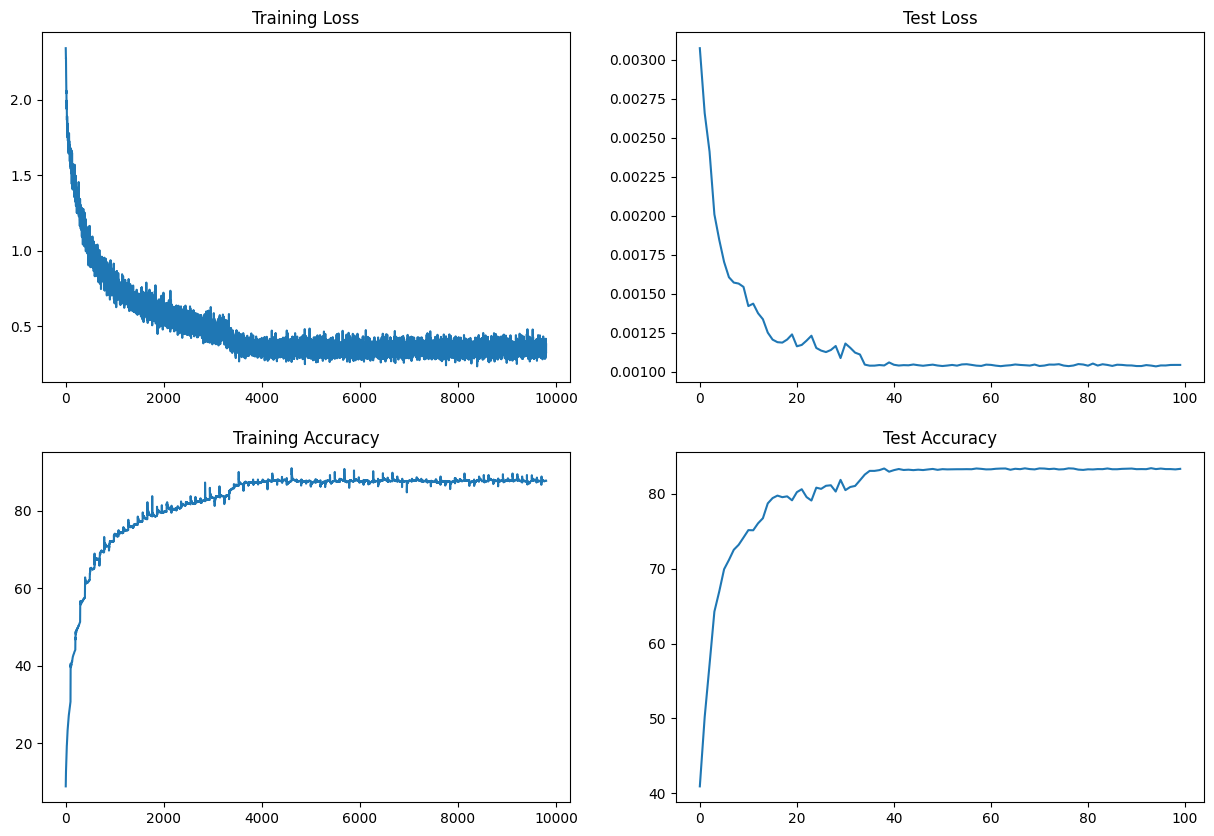

In [7]:
plot_curves(trainer.train_losses,trainer.train_accuracies,tester.test_losses,tester.test_accuracies)

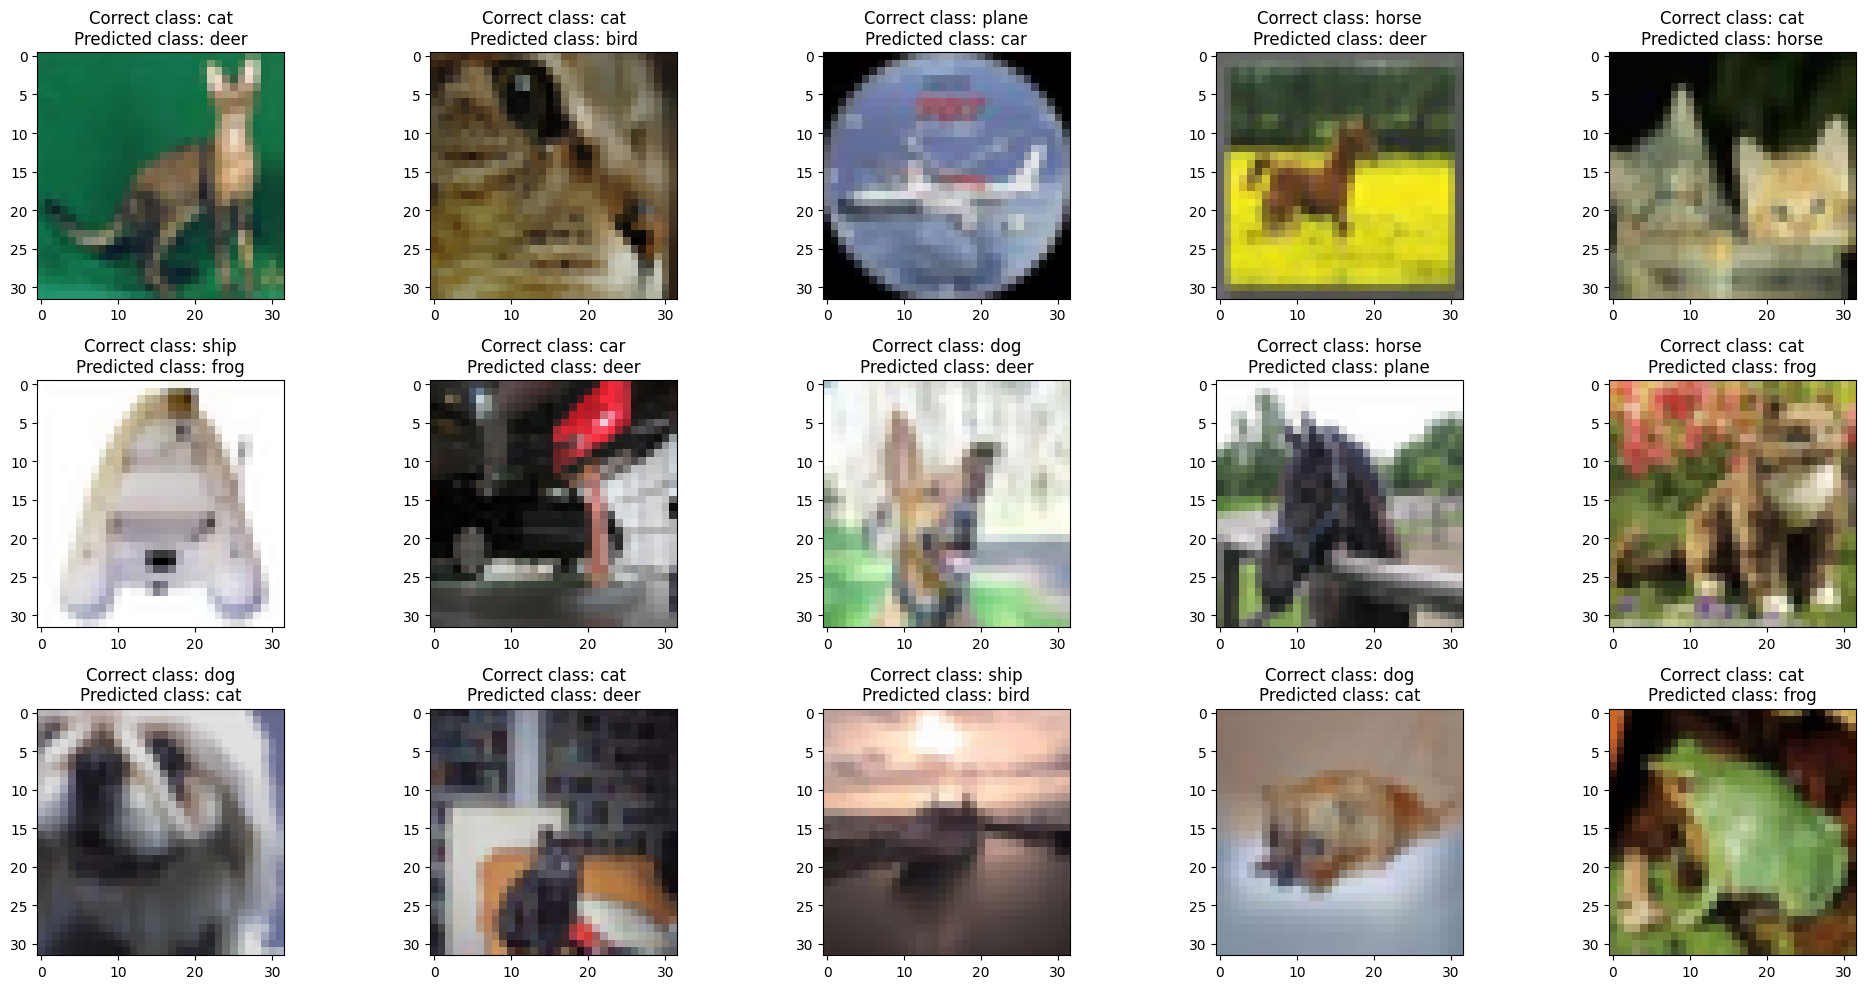

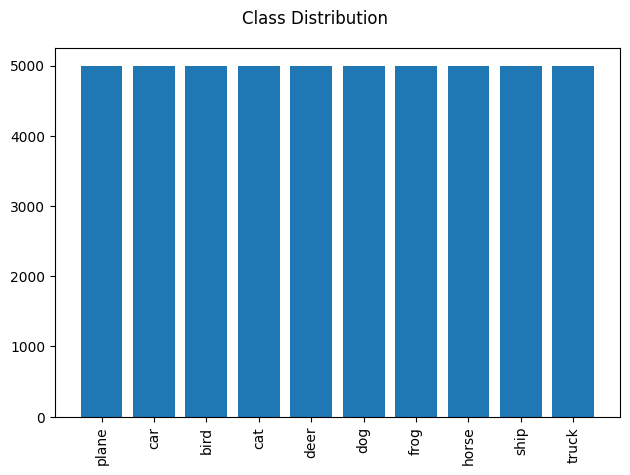

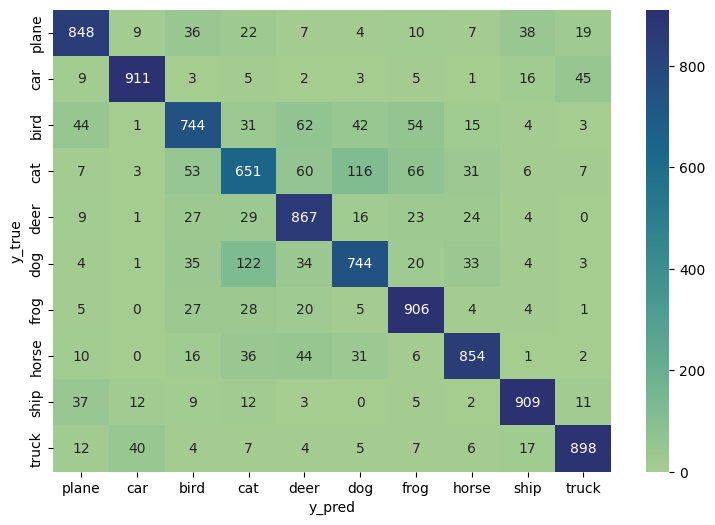

In [8]:
images, predictions, labels =  tester.get_misclassified_images()
show_misclassified_images(images[:15],predictions[:15],labels[:15],cifar.classes)
plot_class_distribution(train_loader,cifar.classes)
plot_confusion_matrix(model,test_loader,device,cifar.classes)